<a href="https://colab.research.google.com/github/Eunhasuiin/WIL/blob/master/DACON_BASIC_Image_classifying_with_CNN_augumentation_Mixup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import zipfile
         
fantasy_zip = zipfile.ZipFile('/content/data.zip')
fantasy_zip.extractall('/content/index')
 
fantasy_zip.close()

**EDA**

In [5]:
import os
import numpy as np
import warnings
warnings.filterwarnings(action='ignore') # 경고 메세지 숨김
from glob import glob
import numpy as np
import matplotlib
import seaborn as sns
import PIL
PIL.Image

<module 'PIL.Image' from '/usr/local/lib/python3.7/dist-packages/PIL/Image.py'>

In [6]:
# 데이터를 불러올 함수를 정의합니다.
def load_CIFAR10(path):
    
    path = path
    images = []
    labels = []
    for filename in glob(path +"*"):
        for img in glob(filename + "/*.jpg"):
            an_img = PIL.Image.open(img) #read img
            img_array = np.array(an_img) #img to array
            images.append(img_array) #append array to training_images
            label = filename.split('/')[4] #get label
            labels.append(label) #append label
    images = np.array(images)
    labels = np.array(labels)
    
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    labels= le.fit_transform(labels)
    labels = labels.reshape(-1,1)
    
    return images, labels

In [7]:
training_images, training_labels = load_CIFAR10(path='/content/index/train/') # path를 다음과 같이 train 폴더로 설정합니다.

In [8]:
print("train 이미지 크기:", training_images.shape)
print("train 라벨 크기:", training_labels.shape)

train 이미지 크기: (50000, 32, 32, 3)
train 라벨 크기: (50000, 1)


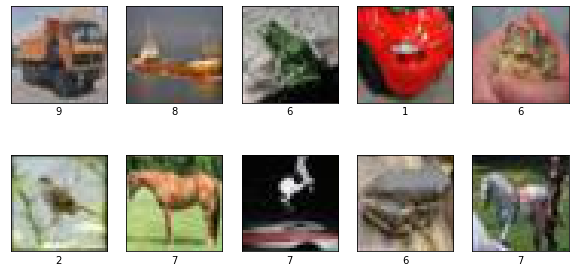

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[10,5])
for i in range(10):
    import random
    num = random.randint(0,50000)
    plt.subplot(2, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(training_labels[num][0])
    plt.imshow(training_images[num])
plt.show()

In [10]:
print(np.unique(training_labels))

[0 1 2 3 4 5 6 7 8 9]


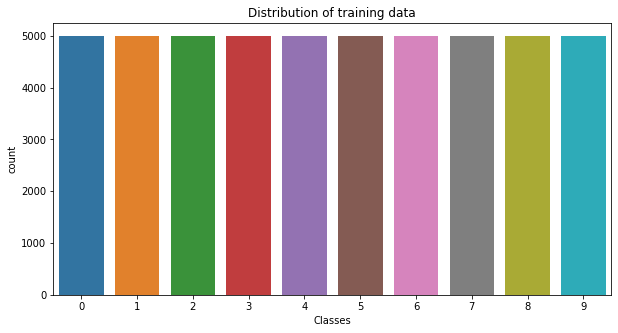

In [11]:
plt.figure(figsize=[10,5])
sns.countplot(training_labels.ravel())
plt.title('Distribution of training data')
plt.xlabel('Classes')
plt.show()

***start_indexing***

In [12]:
#create test dataset

path = '/content/index/test/'

test_images = []
test_idx = []

flist = sorted(glob(path + '*.jpg'))

for filename in flist:
    an_img = PIL.Image.open(filename) #read img
    img_array = np.array(an_img) #img to array
    test_images.append(img_array) #append array to training_images 
    
    label = filename.split('/')[4] #get id 
    test_idx.append(label) #append id
    
test_images = np.array(test_images)

print(test_images.shape)
print(test_idx[0:5])

(10000, 32, 32, 3)
['0000.jpg', '0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg']


[7],[7],[7],[7],[7],[7],[7],[7],[7],[7],

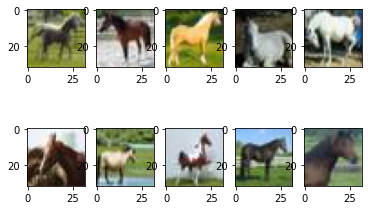

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(training_images[i])
    print(training_labels[i], end=",")
plt.show()

**Data_augumentation**


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

tf.random.set_seed(42)

image_generator = ImageDataGenerator(
    rotation_range=30,
    brightness_range = [0.8, 1.0],
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)

In [17]:
augment_size=150000

np.random.seed(42)

random_mask = np.random.randint(training_images.shape[0], size=augment_size)
training_image_aug = training_images[random_mask].copy()
training_labels_aug = training_labels[random_mask].copy()

In [18]:
training_image_aug = image_generator.flow(training_image_aug, np.zeros(augment_size), batch_size=augment_size, shuffle=False, seed = 42).next()[0]

training_images = np.concatenate((training_images, training_image_aug))
training_labels = np.concatenate((training_labels, training_labels_aug))

In [19]:
print(training_images.shape)
print(training_labels.shape)

(200000, 32, 32, 3)
(200000, 1)


***Mixup_augmentation***
https://everyday-image-processing.tistory.com/145


In [21]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, batch_size = 1, alpha=0.2):
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)

In [24]:
import random
random.seed(42)
from sys import stdout

#training_labels = tf.one_hot(training_labels, 10) #mixup을 적용하기 위해 one-hot 기법을 적용해줍니다

mix_training_images = []
mix_training_labels = []

for i in range(3):
    random_num = random.sample(range(0,50000), 50000) #augmentation을 적용한 데이터를 제외하고 mix해보겠습니다
    print("\nAttempt", i)
    progress_before = 0

    for i in range(0,50000,2):
        image_1 = training_images[random_num[i]]
        label_1 = training_labels[random_num[i]]

        image_2 = training_images[random_num[i+1]]
        label_2 = training_labels[random_num[i+1]]

        mix_image, mix_label = mix_up((image_1, label_1), (image_2, label_2))

        mix_training_images.append(mix_image[0])
        mix_training_labels.append(mix_label[0])
        
        #just for ui
        progress = int(100*(i/49998))
        if progress != progress_before:
            progress_before = progress
            stdout.write("\r ========= %d%% completed =========" %progress)
            stdout.flush()

mix_training_images = np.array(mix_training_images)
mix_training_labels = np.array(mix_training_labels)


Attempt 0
 ========= 100% completed =========
Attempt 1
 ========= 100% completed =========
Attempt 2
 ========= 100% completed =========

In [25]:
print('mix_train 크기:',mix_training_images.shape)
print('mix_label 크기:',mix_training_labels.shape)

mix_train 크기: (75000, 32, 32, 3)
mix_label 크기: (75000, 10)


In [26]:
from sklearn.model_selection import train_test_split

training_labels = np.array(training_labels)
training_labels = training_labels.reshape(-1,10) #mixup에서 one-hot 기법을 적용했다면, shape을 바꿔줍니다.

X_train, X_valid, y_train, y_valid = train_test_split(training_images, 
                                                      training_labels, 
                                                      test_size=0.05, 
                                                      stratify = training_labels, 
                                                      random_state=42)

X_train = np.concatenate((X_train, mix_training_images)) #mixup한 75000개의 데이터를 train set에 추가해줍니다
y_train = np.concatenate((y_train, mix_training_labels))

X_test = test_images

In [27]:
print('X_train 크기:',X_train.shape)
print('y_train 크기:',y_train.shape)
print('X_valid 크기:',X_valid.shape)
print('y_valid 크기:',y_valid.shape)
print('X_test  크기:',X_test.shape)

X_train 크기: (265000, 32, 32, 3)
y_train 크기: (265000, 10)
X_valid 크기: (10000, 32, 32, 3)
y_valid 크기: (10000, 10)
X_test  크기: (10000, 32, 32, 3)


In [ ]:
X_train = X_train / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

**CNN_cell**

In [1]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='SAME',input_shape=(32, 32, 3)), #cnn layer
    tf.keras.layers.BatchNormalization(), #batch norm layer
    
    tf.keras.layers.MaxPooling2D(2, 2, padding='SAME'), #pooling layer
    
    tf.keras.layers.GlobalAveragePooling2D(), #pooling layer

    tf.keras.layers.Dense(256, activation = 'relu'), #fully connected layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation = 'relu'), #fully connected layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation = 'softmax') # ouput layer
])

In [2]:
EPOCH = 32
BATCH_SIZE = 128

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',  # 모니터 기준 설정 (val loss) 
                              patience=5,         # 5 Epoch동안 개선되지 않는다면 종료
                             )

reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
)

data = model.fit(X_train, 
                 y_train, 
                 validation_data=(X_valid, y_valid), 
                 epochs=EPOCH, 
                 batch_size=BATCH_SIZE, 
                 callbacks=[reduceLR, earlystopping],)

NameError: ignored

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 32)          0

In [64]:
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=256)

Epoch 1/20
157/157 [==============================] - 44s 275ms/step - loss: 0.8594 - accuracy: 0.6966 - val_loss: 0.8066 - val_accuracy: 0.7207
Epoch 2/20
157/157 [==============================] - 42s 266ms/step - loss: 0.8555 - accuracy: 0.6970 - val_loss: 0.8265 - val_accuracy: 0.7125
Epoch 3/20
157/157 [==============================] - 42s 269ms/step - loss: 0.8434 - accuracy: 0.7024 - val_loss: 0.7984 - val_accuracy: 0.7246
Epoch 4/20
157/157 [==============================] - 42s 268ms/step - loss: 0.8389 - accuracy: 0.7030 - val_loss: 0.8014 - val_accuracy: 0.7205
Epoch 5/20
157/157 [==============================] - 42s 271ms/step - loss: 0.8193 - accuracy: 0.7079 - val_loss: 0.7740 - val_accuracy: 0.7354
Epoch 6/20
157/157 [==============================] - 42s 267ms/step - loss: 0.8118 - accuracy: 0.7115 - val_loss: 0.7734 - val_accuracy: 0.7326
Epoch 7/20
157/157 [==============================] - 42s 266ms/step - loss: 0.8079 - accuracy: 0.7140 - val_loss: 0.7734 - val_ac